In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

In [2]:
# Load and preprocess data
data = pd.read_csv('text.csv')
df = pd.DataFrame(data)

In [3]:
df = df.dropna(subset=['text', 'label'])

In [4]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    df["text"], df["label"], test_size=0.2, random_state=42, stratify=df["label"]
)


In [6]:
# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=10000, stop_words='english', ngram_range=(1, 3))
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)


In [7]:
# Model Training
param_grid = {
    'C': [0.1, 1, 10],
    'solver': ['liblinear', 'lbfgs'],
    'max_iter': [100, 200]
}

lr = LogisticRegression(class_weight='balanced', random_state=42)
grid_search = GridSearchCV(lr, param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train_vec, y_train)

model = grid_search.best_estimator_

c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stab

In [8]:
# Save model and vectorizer
pickle.dump(model, open('emotion_model.sav', 'wb'))
pickle.dump(vectorizer, open('vectorizer.sav', 'wb'))

Accuracy: 0.9125020992778484

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.93      0.95     24238
           1       0.96      0.90      0.93     28214
           2       0.75      0.94      0.83      6911
           3       0.90      0.93      0.92     11463
           4       0.88      0.86      0.87      9542
           5       0.70      0.94      0.80      2994

    accuracy                           0.91     83362
   macro avg       0.86      0.92      0.88     83362
weighted avg       0.92      0.91      0.91     83362



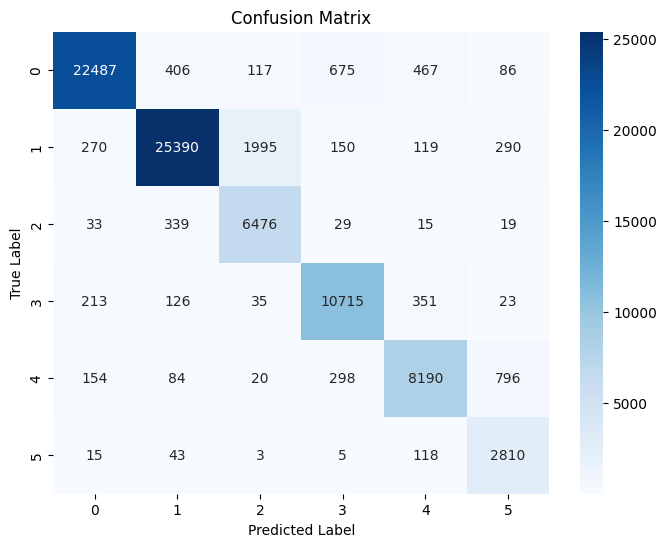

In [9]:
# Evaluate the model
y_pred = model.predict(X_test_vec)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=df['label'].astype('category').cat.categories,
    yticklabels=df['label'].astype('category').cat.categories
)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

In [10]:
# Prediction with similarity-based fallback
input_data = "i just feel really helpless and heavy hearted"
input_data_vec = vectorizer.transform([input_data])
prediction = model.predict(input_data_vec)
probabilities = model.predict_proba(input_data_vec)

In [11]:
# Define emotion labels
emotions = {
    0: "Neutral",
    1: "Happiness",
    2: "Excitement",
    3: "Calm",
    4: "Sadness",
    5: "Fatigue"
}

predicted_emotion = emotions.get(prediction[0], "Unknown")
print(f"Input Text: {input_data}")
print(f"Predicted Emotion: {predicted_emotion}")

Input Text: i just feel really helpless and heavy hearted
Predicted Emotion: Neutral


In [12]:
# Fallback using cosine similarity
def find_most_similar(input_text, dataset, vectorizer):
    input_vec = vectorizer.transform([input_text])
    dataset_vec = vectorizer.transform(dataset)
    similarity = cosine_similarity(input_vec, dataset_vec)
    most_similar_index = np.argmax(similarity)
    return dataset.iloc[most_similar_index]

if max(probabilities[0]) < 0.5:  # Low confidence fallback
    similar_text = find_most_similar(input_data, df['text'], vectorizer)
    print(f"Model is uncertain. Most similar text in dataset: \"{similar_text}\".")

if prediction[0] == 4:
    print("The model predicts that the emotion is sadness.")
elif prediction[0] == 1:
    print("The model predicts that the emotion is happiness.")
else:
    print(f"The model predicts that the emotion is {predicted_emotion}.")

Model is uncertain. Most similar text in dataset: "i just feel really helpless and heavy hearted".
The model predicts that the emotion is Neutral.
